### Objective 

This notebook is about applying deep learning models to predict the helpfulness of the amazon review dataset. We have already applied traditonal model approach to  the problem statement. Based on the traditional approach, using SMOTE Sampling TF-IDF RandomForest Classifier accuracy score was about 73% and precision score as 84%. You can find the details about the traditional approach in the github link: 

https://github.com/subhashree-ai/amazon-review-helpfulness-prediction/blob/master/notebooks/amazon_helpfulness_prediction_trad_models.ipynb


In this notebook, we will apply LSTM deep learning methods on the amazon review datasets and will take into account threshold value as 0.5 for labelling the target variable. This will lead us to highly imbalanced datasets. We will employ 3 different methods and compare which one suits best for our imbalanced datasets. 

1. Setting the initial bias
2. Setting weights for balancing the datasets
3. Oversampling the minority class

##### Import and Initialization

In [1]:
# Importing the relevant dependencies
import numpy as np
import pandas as pd
import gzip
import math, time, random, datetime
import string
import os
import tempfile

# data visualization
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
mpl.rcParams['figure.figsize'] = (5, 5)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from IPython.display import display # Allows the use of display() for DataFrames
import warnings
warnings.filterwarnings('ignore')
import pickle
from sklearn.model_selection import train_test_split

# Deep Learning Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\src\\utils")

In [3]:
from custom_text_preprocessing import normalize_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from plotting import plot_cm, plot_loss, plot_metrics, plot_roc_dl

In [5]:
# folder where input data and pickle data load present
data_folder = '../data/dataLoad/'
input_folder = '../data/raw/'

##### Data Loading 

This module is about loading the amazon review dataset and filtering the product reviews less than 10 product reviews and removing some of the outliers and deriving the target variable having threshold as 0.5(standard one). 

In [6]:
# Loading the home and kitchen dataset which is downloaded in the /data path
input_data = 'reviews_Home_and_Kitchen_5.json.gz'
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i +=1
    return pd.DataFrame.from_dict(df, orient='index')

data = getDF(input_folder + input_data)   

# Data Preprocessing
# Filter the products which has atleast 10 reviews
groupby_product = data.groupby('asin').size()
filter_reviews = data.groupby('asin').size().values >= 10
filter_asins = groupby_product[filter_reviews].index
data_filter = data.loc[data['asin'].isin(filter_asins), :]

# Filter the reviews having more than 10 helpful reviews
dataset = data_filter[data_filter['helpful'].apply(lambda x: x[1] > 10)]

#Deriving the target variables from features
dataset['helpful_ratings'] = dataset['helpful'].apply(lambda x: x[0])
dataset['total_ratings'] = dataset['helpful'].apply(lambda x: x[1])

# Droping some of the outliers
dataset = dataset.drop(dataset.index[dataset.helpful_ratings == dataset.helpful_ratings.max()])
dataset = dataset.drop(dataset.index[dataset.total_ratings > 1000])

# This funcion will get the helpfulness rating based on certain threshold and total and helpful ratings count
def getHelpfulness(input_dataset, threshold):
    threshold=threshold
    input_dataset.loc[:, 'isHelpful'] = np.where(input_dataset['helpful_ratings']/input_dataset['total_ratings'] > threshold, 1, 0)
    
    return input_dataset

# Dataset with threshold 0.5
dataset_threshold_05 = getHelpfulness(dataset, threshold=0.5)
dataset_threshold_05 = dataset.drop(columns = ['helpful', 'helpful_ratings', 'total_ratings'], axis=1)
dataset_threshold_05 = dataset_threshold_05.reset_index(drop=True)

Dataset Description:


As mentioned in the jmcauley site, belaw are the description of the fields:
1. reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
2. asin - ID of the product, e.g. 0000013714
3. reviewerName - name of the reviewer
4. helpful - helpfulness rating of the review, e.g. 2/3.
5. reviewText - text of the review
6. overall - rating of the product
7. summary - summary of the review
8. unixReviewTime - time of the review (unix time)
9. reviewTime - time of the review (raw)

The approach to the problem, will be to normalize the review text and then and apply LSTM model. And in the course of training the model, we will employ different strategies to handle the skewness of the dataset.

We are splitting the data to train, test and validation datset. We use validation dataset to optimize the training and then apply test dataset(unseen dataset) to trained mode to get the accuracy and precision.

##### Normalize the reviewText  and Train-Test split the dataset

In [7]:
def get_normalize_text_data(dataset):
    start = time.time()
    dataset['normalize_review_text'] = dataset['reviewText'].apply(lambda x: normalize_text(x))
    dataset = dataset.drop(columns=['reviewText'])
    end = time.time()
    
    print('Total time to normalize the text data {:4f} seconds'.format(end - start))
    return dataset

In [8]:
dataset_threshold_05 = get_normalize_text_data(dataset_threshold_05)

Total time to normalize the text data 21.871655 seconds


In [9]:
X = dataset_threshold_05['normalize_review_text'].values
y = dataset_threshold_05['isHelpful'].values

# Split the data into train, test and validation set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [10]:
print('Training labels shape:', y_train.shape)
print('Validation labels shape:', y_val.shape)
print('Test labels shape:', y_test.shape)

print('Training features shape:', X_train.shape)
print('Validation features shape:', X_val.shape)
print('Test features shape:', X_test.shape)

Training labels shape: (17540,)
Validation labels shape: (4386,)
Test labels shape: (5482,)
Training features shape: (17540,)
Validation features shape: (4386,)
Test features shape: (5482,)


In [11]:
# Look at the data distribution
train_labels_df = pd.DataFrame(y_train, columns = ['isHelpful'])

neg, pos = np.bincount(train_labels_df['isHelpful'])
total = neg + pos
print('Examples:\n    Total: {}\n    Not Helpful: {} ({:.2f}% of total)\n'.format(
    total, neg, 100 * neg / total))                      

Examples:
    Total: 17540
    Not Helpful: 1032 (5.88% of total)



##### Defining the embedding for reviewText 

In [12]:
embedding_size = 200
num_words = 10000
max_tokens = 100

In [13]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_features = tokenizer.texts_to_sequences(X_train)
X_val_features = tokenizer.texts_to_sequences(X_val)
X_test_features = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
print(X_train[2])
print(X_train_features[2])

really quite bad cordless vacuumit almost suction write really tested turn floor mode put hand nozzle feel nearly nothing put white powder carpet freshner turn boss carpet mode see long takes remove white powder run another vacuum across areayou prove picks minimal amount powder mutliple passes required thatnot recommended
[13, 152, 256, 1425, 169, 327, 1713, 13, 1319, 184, 181, 988, 33, 115, 1503, 182, 646, 277, 33, 313, 1577, 244, 184, 3470, 244, 988, 66, 65, 201, 247, 313, 1577, 276, 85, 35, 773, 3937, 2025, 1980, 242, 1577, 2557, 1034, 564]


In [14]:
len(tokenizer.word_index)

84453

In [15]:
X_train_features = pad_sequences(X_train_features, padding='post', maxlen=max_tokens)
X_val_features = pad_sequences(X_val_features, padding='post', maxlen=max_tokens)
X_test_features = pad_sequences(X_test_features, padding='post', maxlen=max_tokens)

print(X_train_features[0, :])

[ 383 2239 3212   19 1466  159  666  506  649  246  400  291    8  158
  858   92  249 1109  249  128 2352  404 2909  461   55 1402  396  483
 1721 2706  404 2370    9  128  134 9772  160  158  404  461 2221 1300
 1970 1248   99 4543  160  275    7   28   27   55  461  198  820 4037
  123  820  167    3  300   32  118  101   46    5    9 1091  291 7931
   96 1529  567  160 1086 9297   48  412   64  560    6  309   55  613
 1529  567 7932   69   14  369   26  103   12  214   50  299   76 1341
  702   55]


In [16]:
X_train_features.shape

(17540, 100)

##### Define the model and metrics 

In [17]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

#Create Model with all the param_grid as arguments
def create_model(dropout_rate=0.2, activation='sigmoid', learning_rate=1e-3, metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    else:
        output_bias = tf.keras.initializers.Constant(value=0)
    model = keras.models.Sequential([
        keras.layers.Embedding(input_dim=num_words, output_dim=embedding_size,
                            input_length=max_tokens, name='layer_embedding'),
        keras.layers.LSTM(units=128, dropout=dropout_rate, return_sequences=True),
        keras.layers.LSTM(units=64, dropout=dropout_rate, return_sequences=True),
        keras.layers.LSTM(units=12, dropout=dropout_rate),
        keras.layers.Dense(1, activation=activation,
                            bias_initializer=output_bias)
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(lr=learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)
    return model

##### Baseline Model 

The model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no not helpful reviews to learn from.

In [18]:
# Build the model
EPOCHS= 20
BATCH_SIZE = 1000

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [19]:
# Without setting any initial bias
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_embedding (Embedding)  (None, 100, 200)          2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100, 128)          168448    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 64)           49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 12)                3696      
_________________________________________________________________
dense (Dense)                (None, 1)                 13        
Total params: 2,221,565
Trainable params: 2,221,565
Non-trainable params: 0
_________________________________________________________________


In [20]:
results = model.evaluate(X_train_features, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.7002


##### Set the correct initial bias 

As we know that out dataset is imbalanced, setting an putput layer bias can help with initial convergence.

The correct bias to set can be derived from:

                        p0 = pos/(pos + neg) = 1/(1 + e^-b0)
                        b0 = -loge(1/p0 -1 )
                        b0 = loge(pos/neg)    

In [21]:
initial_bias = np.log([neg/pos])
initial_bias

array([-2.77234644])

In [22]:
model = create_model(output_bias=initial_bias)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_embedding (Embedding)  (None, 100, 200)          2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 128)          168448    
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 64)           49408     
_________________________________________________________________
lstm_5 (LSTM)                (None, 12)                3696      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 2,221,565
Trainable params: 2,221,565
Non-trainable params: 0
_________________________________________________________________


In [23]:
results = model.evaluate(X_train_features, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 2.6588


After setting the initial bias, it increased the lose to about 150%. But still we will just checkout and experiment on how the initial bias looks like. It increase in loss might be also the case of very less negative cases in the dataset.

##### Checkpoint the initial weights 

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training

In [24]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

###### Confirm that bias fix helps 

In [26]:
model = create_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(X_train_features,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_features, y_val), 
    verbose=0)

In [27]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train_features,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_features, y_val), 
    verbose=0)

In [28]:
def plot_loss(history, label, n):
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.legend()

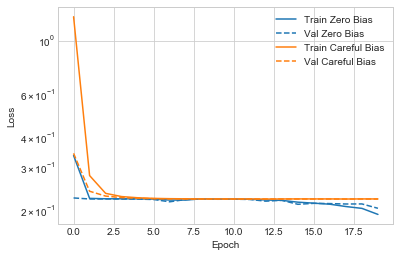

In [29]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [30]:
model = create_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
baseline_history = model.fit(
    X_train_features,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_val_features, y_val))

Train on 17540 samples, validate on 4386 samples
Epoch 1/20
17540/17540 [==============================] - 114s 7ms/sample - loss: 0.3385 - tp: 16332.0000 - fp: 1027.0000 - tn: 5.0000 - fn: 176.0000 - accuracy: 0.9314 - precision: 0.9408 - recall: 0.9893 - auc: 0.4962 - val_loss: 0.2256 - val_tp: 4128.0000 - val_fp: 258.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.9412 - val_precision: 0.9412 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 2/20
17540/17540 [==============================] - 104s 6ms/sample - loss: 0.2242 - tp: 16508.0000 - fp: 1032.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.9412 - precision: 0.9412 - recall: 1.0000 - auc: 0.5109 - val_loss: 0.2237 - val_tp: 4128.0000 - val_fp: 258.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.9412 - val_precision: 0.9412 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/20
17540/17540 [==============================] - 103s 6ms/sample - loss: 0.2239 - tp: 16508.0000 - fp: 1032.0000 - tn: 0.000

In [31]:
train_predictions_baseline = model.predict(X_train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test_features, batch_size=BATCH_SIZE)

loss :  0.2308316201254296
tp :  5006.0
fp :  253.0
tn :  70.0
fn :  153.0
accuracy :  0.92593944
precision :  0.951892
recall :  0.9703431
auc :  0.7133858

Not Helpful reviews Detected (True Negatives):  70
Not Helpful reviews Incorrectly Detected (False Positives):  253
Helpful Reviews Missed (False Negatives):  153
Helpful Reviews Detected (True Positives):  5006
Total Helpful Reviews:  5159


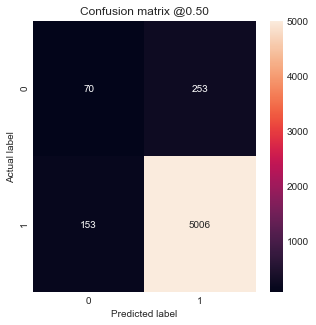

In [32]:
# Display confusion matrix and classification report
baseline_results = model.evaluate(X_test_features, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

In [33]:
# train the model with early stopping 
model_bias = create_model()
model_bias.load_weights(initial_weights)
baseline_history = model_bias.fit(
    X_train_features,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_val_features, y_val))

Train on 17540 samples, validate on 4386 samples
Epoch 1/20
17540/17540 [==============================] - 118s 7ms/sample - loss: 1.2527 - tp: 6327.0000 - fp: 393.0000 - tn: 639.0000 - fn: 10181.0000 - accuracy: 0.3971 - precision: 0.9415 - recall: 0.3833 - auc: 0.4811 - val_loss: 0.3441 - val_tp: 4128.0000 - val_fp: 258.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.9412 - val_precision: 0.9412 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 2/20
17540/17540 [==============================] - 104s 6ms/sample - loss: 0.2778 - tp: 16508.0000 - fp: 1032.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.9412 - precision: 0.9412 - recall: 1.0000 - auc: 0.5096 - val_loss: 0.2407 - val_tp: 4128.0000 - val_fp: 258.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.9412 - val_precision: 0.9412 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/20
17540/17540 [==============================] - 105s 6ms/sample - loss: 0.2362 - tp: 16508.0000 - fp: 1032.0000 - tn: 0.0

In [34]:
# Evaluate metrics
train_predictions_bias = model_bias.predict(X_train_features, batch_size=BATCH_SIZE)
test_predictions_bias = model_bias.predict(X_test_features, batch_size=BATCH_SIZE)

loss :  0.34420796502510675
tp :  5159.0
fp :  323.0
tn :  0.0
fn :  0.0
accuracy :  0.9410799
precision :  0.9410799
recall :  1.0
auc :  0.5

Not Helpful reviews Detected (True Negatives):  0
Not Helpful reviews Incorrectly Detected (False Positives):  323
Helpful Reviews Missed (False Negatives):  0
Helpful Reviews Detected (True Positives):  5159
Total Helpful Reviews:  5159


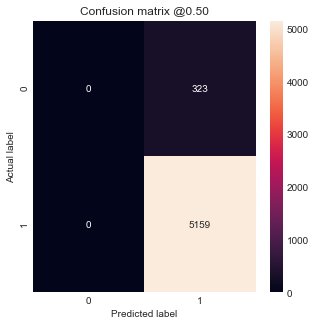

In [35]:
# Display confusion matrix and classification report
baseline_results_bias = model_bias.evaluate(X_test_features, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model_bias.metrics_names, baseline_results_bias):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_bias)

As per the above confusion matrix and classification report, it is very clear that initial bias dodnt help much as we still as its still not clearly able to predict the not helpful reviews. The fact might be because of imbalance dataset having huge number of helpful reviews

Next, we will try to handle the imbalance dataset using the class weights concept in tensorflow

###### Training  model with class weights 

In [36]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 8.50
Weight for class 1: 0.53


In [37]:
weighted_model = create_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train_features,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_val_features, y_val),
    # The class weights go here
    class_weight=class_weight) 

Train on 17540 samples, validate on 4386 samples
Epoch 1/20
17540/17540 [==============================] - 117s 7ms/sample - loss: 0.9079 - tp: 4893.0000 - fp: 288.0000 - tn: 744.0000 - fn: 11615.0000 - accuracy: 0.3214 - precision: 0.9444 - recall: 0.2964 - auc: 0.5008 - val_loss: 0.7028 - val_tp: 4128.0000 - val_fp: 258.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.9412 - val_precision: 0.9412 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 2/20
17540/17540 [==============================] - 107s 6ms/sample - loss: 0.6962 - tp: 7716.0000 - fp: 484.0000 - tn: 548.0000 - fn: 8792.0000 - accuracy: 0.4712 - precision: 0.9410 - recall: 0.4674 - auc: 0.4991 - val_loss: 0.6927 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 258.0000 - val_fn: 4128.0000 - val_accuracy: 0.0588 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 3/20
17540/17540 [==============================] - 108s 6ms/sample - loss: 0.6926 - tp: 9504.0000 - fp: 567.0000 - tn: 46

In [38]:
# Evaluate metrics
train_predictions_weighted = weighted_model.predict(X_train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_test_features, batch_size=BATCH_SIZE)

loss :  0.3171341765844574
tp :  4873.0
fp :  236.0
tn :  87.0
fn :  286.0
accuracy :  0.90477926
precision :  0.953807
recall :  0.9445629
auc :  0.75745356

Not Helpful reviews Detected (True Negatives):  87
Not Helpful reviews Incorrectly Detected (False Positives):  236
Helpful Reviews Missed (False Negatives):  286
Helpful Reviews Detected (True Positives):  4873
Total Helpful Reviews:  5159


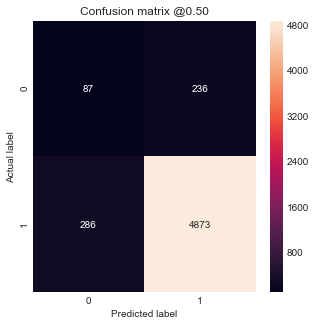

In [39]:
# Display confusion matrix and classification report
weighted_results = weighted_model.evaluate(X_test_features, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)

 The class weights showed better improvement in identifying the not helpful reviews. Next we will try oversampling the minority class, in our case it is not helpful review features. 

###### Train model using oversampling the minority class 

In [40]:
bool_train_labels = y_train !=0

pos_features = X_train_features[bool_train_labels]
neg_features = X_train_features[~bool_train_labels]

pos_labels = y_train[bool_train_labels]
neg_labels = y_train[~bool_train_labels]

In [41]:
# balance the dataset manually by choosing the right number of random indices from the negative examples using tf.data
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [42]:
# Each dataset provides (feature, label) pairs:
for features, label in pos_ds.take(1):
    print("Features:\n", features.numpy())
    print()
    print("Label: ", label.numpy())

Features:
 [  24  341  179   30   52   47  203    3 2364 2091 3390 1454  179  434
  107  347 5199  868  255  179 2016 1330 2157  574    8 1190 4601 5199
   80  176    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]

Label:  1


In [43]:
#Merge the two together using experimental.sample_from_datasets:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [44]:
#Merge the two together using experimental.sample_from_datasets:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [45]:
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

0.488


In [46]:
#To use this dataset, you'll need the number of steps per epoch.
#The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

3.0

In [48]:
#training the model with the resampled data set instead of using class weights to see how these methods compare
resampled_model = create_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((X_val_features, y_val)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=40,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_ds)

Train for 3.0 steps, validate for 5 steps
Epoch 1/40
3/3 [==============================] - 37s 12s/step - loss: 0.6846 - tp: 502.0000 - fp: 499.0000 - tn: 1034.0000 - fn: 965.0000 - accuracy: 0.5120 - precision: 0.5015 - recall: 0.3422 - auc: 0.5653 - val_loss: 0.8427 - val_tp: 1563.0000 - val_fp: 31.0000 - val_tn: 227.0000 - val_fn: 2565.0000 - val_accuracy: 0.4081 - val_precision: 0.9806 - val_recall: 0.3786 - val_auc: 0.6655
Epoch 2/40
3/3 [==============================] - 24s 8s/step - loss: 0.6721 - tp: 583.0000 - fp: 200.0000 - tn: 1319.0000 - fn: 898.0000 - accuracy: 0.6340 - precision: 0.7446 - recall: 0.3937 - auc: 0.6604 - val_loss: 0.7931 - val_tp: 1662.0000 - val_fp: 34.0000 - val_tn: 224.0000 - val_fn: 2466.0000 - val_accuracy: 0.4300 - val_precision: 0.9800 - val_recall: 0.4026 - val_auc: 0.6782
Epoch 3/40
3/3 [==============================] - 24s 8s/step - loss: 0.6578 - tp: 669.0000 - fp: 240.0000 - tn: 1243.0000 - fn: 848.0000 - accuracy: 0.6373 - precision: 0.7360 

In [49]:
# Evaluate metrics
train_predictions_resampled = resampled_model.predict(X_train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(X_test_features, batch_size=BATCH_SIZE)

loss :  0.3374970595534811
tp :  4506.0
fp :  152.0
tn :  171.0
fn :  653.0
accuracy :  0.8531558
precision :  0.96736795
recall :  0.87342507
auc :  0.808105

Not Helpful reviews Detected (True Negatives):  171
Not Helpful reviews Incorrectly Detected (False Positives):  152
Helpful Reviews Missed (False Negatives):  653
Helpful Reviews Detected (True Positives):  4506
Total Helpful Reviews:  5159


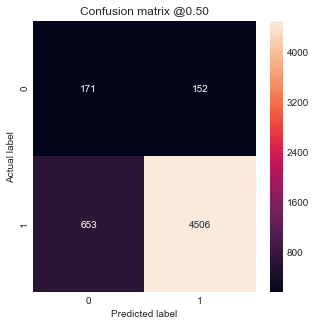

In [50]:
# Display confusion matrix and classification report
resampled_results = resampled_model.evaluate(X_test_features, y_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_resampled)

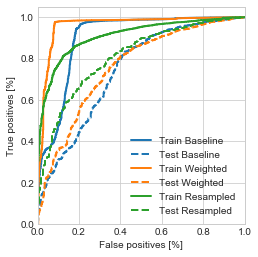

In [51]:
# Plot roc for all the different strategies followed for handling the imbalance dataset
plot_roc_dl("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc_dl("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc_dl("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc_dl("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc_dl("Train Resampled", y_train, train_predictions_resampled,  color=colors[2])
plot_roc_dl("Test Resampled", y_test, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='lower right')

As per our experiments, oversampling teh minority class along with assigning class weights worked the best for predicting the helpfulness of the reviews setting an accuracy of around 85%.

Future work, we can still optimize the solutions by checking on different parameter optimization like learning_rate, dropout etc. And can try bidirectional attention model for training the model.

References:

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

https://realpython.com/python-keras-text-classification/

https://medium.com/@margaretmz/setting-up-aws-ec2-for-running-jupyter-notebook-on-gpu-c281231fad3f